# Unified Model, Multiple Weighted Strategic Agents Clique Network

## Additional Tests for Comparative Statics: $\alpha_1$ near $1$

James Yu, 3 September 2024

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def should_terminate(bundles, eps):
    return all([np.allclose(b[0], b[1], rtol = eps, atol = eps) for b in bundles])

def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    eps = np.sqrt(np.finfo(np.float64).eps)
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        historical_K.insert(0, K_new)
        historical_k.insert(0, k_new)
        historical_kappa.insert(0, kappa_new)
        if should_terminate([(K_t, K_new), (k_t, k_new), (kappa_t, kappa_new)], eps):
            return historical_K[0], historical_k[0], historical_kappa[0]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new

In [5]:
def optimal(U, X_init, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, eps):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    tilde_rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(int)
    
    M_ = M(K_ss, B, R, L, delta)
    H_ = H(B, K_ss, A, L)
    E_ = E(M_, H_)
    G_ = G(A, B, E_, L, n)
    F_ = [F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n) for l in range(L)]
    g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
    
    i = 0
    while True:
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_ss, k_ss, l, L, c, x, n), l, n)
            tilde_rs[l].append(U.T @ Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if l == L - 1 and np.allclose(X_t[l], X_new, rtol = eps, atol = eps):
                return xs, tilde_rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, tilde_rs, payoffs

In [6]:
def eigensort(A):
    """Sort eigenvalues largest to smallest so the "1" comes first."""
    # the underlying process turns out to be a common implementation
    # regardless, partial inspiration for the underlying process from: 
    # https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
    # implementation reverse-engineered using the NumPy documentation
    eigvals_raw, U_raw = np.linalg.eig(A)
    eigval_sorting_map = np.flip(np.argsort(eigvals_raw)) 
    eigvals = eigvals_raw[eigval_sorting_map]
    U = U_raw[:, eigval_sorting_map]
    if U[0, 0] < 0:
        # if the first eigenvector is negative, flip the sign
        U[:, 0] *= -1
    return eigvals, U

In [7]:
def tilde_Kj(c, delta, a1, a2, lambdaj):
    """Numerically solve the coupled Ricatti equations."""
    g1 = lambda x, y: x - (1 + (c*delta * lambdaj**2 * x * (delta*x*a1**2 + c))/((c+delta*x*a1**2 + delta*y*a2**2)**2))
    g2 = lambda x, y: y - (1 + (c*delta * lambdaj**2 * y * (delta*y*a2**2 + c))/((c+delta*x*a1**2 + delta*y*a2**2)**2))
    g = lambda x: [g1(x[0], x[1]), g2(x[0], x[1])]
    res = fsolve(g, [0, 0])
    if np.allclose(res, [0, 0]):
        # using [0, 0] as the initial point allows stronger distinction
        # between solver failure and correct-but-small solutions, since x, y > 1.
        raise Exception(f"fsolve failed to initialize: c = {c}, delta = {delta}, alpha1 = {a1}, alpha2 = {a2}, lambdaj = {lambdaj}")
    if not np.allclose(g(res), [0, 0]):
        # detects if solution isn't actually the solution
        raise Exception(f"fsolve failed to solve: c = {c}, delta = {delta}, alpha1 = {a1}, alpha2 = {a2}, lambdaj = {lambdaj}: {g(res)} != [0, 0]")
    return res

In [8]:
def solve_projected(A, delta, c, a1, a2, b1, b2):
    """Solve for the optimal solution matrices and vectors."""
    eigvals, U = eigensort(A)
    #print("Eigenvalues:")
    #print(eigvals)
    #print()
    #print("U:")
    #print(U)
    #print()
    D = np.diag(eigvals)
    n = len(eigvals)
    #print("U * D * U':")
    #print(U @ D @ U.T)
    #print()
    
    tilde_b1 = U.T @ (b1 * np.ones((n, 1)))
    tilde_b2 = U.T @ (b2 * np.ones((n, 1)))
    
    tilde_K_constructor = [tilde_Kj(c, delta, a1, a2, lambdaj) for lambdaj in eigvals]
    tilde_K1 = np.diag([K[0] for K in tilde_K_constructor])
    tilde_K2 = np.diag([K[1] for K in tilde_K_constructor])
    
    I = np.identity(n)
    Gamma = np.linalg.inv(c*I + delta*a1**2 * tilde_K1 + delta*a2**2 * tilde_K2)
    Y = I - delta * Gamma @ Gamma @ D @ (delta * a1**2 * tilde_K1 + c*I) @ (delta * a2**2 * tilde_K2 + c*I)
    Z1 = delta**2 * a2**2 * Gamma @ D @ (delta * a1**2 * tilde_K1 + c*I) @ tilde_K1 @ Gamma
    Z2 = delta**2 * a1**2 * Gamma @ D @ (delta * a2**2 * tilde_K2 + c*I) @ tilde_K2 @ Gamma
    
    tilde_Kk1 = np.linalg.inv(Y @ Y - Z1 @ Z2) @ (Y @ tilde_b1 - Z1 @ tilde_b2)
    tilde_Kk2 = np.linalg.inv(Y @ Y - Z1 @ Z2) @ (Y @ tilde_b2 - Z2 @ tilde_b1)
    
    return tilde_K1, tilde_K2, tilde_Kk1, tilde_Kk2, U

In [9]:
def run_simulation(A, b1, b2, a1, a2, delta = 0.8, c = 1, X_0_1 = np.array([[10.0, 0.0, 0.0, 0.0]], ndmin = 2).T, symmetric = True, print_ = False, tol = np.sqrt(np.finfo(np.float64).eps)):
    tilde_K1, tilde_K2, tilde_Kk1, tilde_Kk2, U = solve_projected(A, delta, c, a1, a2, b1, b2)
    
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    n = 4 # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c * np.identity(n), c * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [a1 * np.identity(n), a2 * np.identity(n)] # B^l = a_l I_n
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    
    K_ss, k_ss, kappa_ss = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol)
    xs, tilde_rs, payoffs = optimal(U, X_0, K_ss, k_ss, A, B, delta, n, L, Q, R, x, c, tol)
    if print_:
        print("Network:")
        print(A)
        print()
        print("Unprojected Steady-State Opinions:")
        print(xs[0][-1] + b1)
        print("Projected Steady-State Opinions:")
        print(U.T @ (xs[0][-1] + b1))
        print()
        print("Projected Steady-State Messages:")
        print("1:")
        print(tilde_rs[0][-1])
        print()
        print("2:")
        print(tilde_rs[1][-1])
        print()
        print()
        print("Projected Messages:")
        print("1:")
        for tilde_r_1 in tilde_rs[0]:
            print(tilde_r_1.T)
        print()
        print("2:")
        for tilde_r_2 in tilde_rs[1]:
            print(tilde_r_2.T)
        print()
        print()
        print("Total Payoffs:")
        print("1:", payoffs[0][-1])
        print("2:", payoffs[1][-1])
        print()
        print("Cumulative Payoffs:")
        print("1:")
        for payoff_1 in payoffs[0]:
            print(payoff_1)
        print()
        print("2:")
        for payoff_2 in payoffs[1]:
            print(payoff_2)
        print()
        print()
        print("Average of agendas:")
        print((b1+b2)/2)
        print()
        print("tilde_K^*:")
        print("1:")
        print(tilde_K1)
        print()
        print("2:")
        print(tilde_K2)
        print()
        print()
        print("(tilde_K * tilde_k)^*:")
        print("1:")
        print(tilde_Kk1)
        print()
        print("2:")
        print(tilde_Kk2)
        print()
        print()
        print("tilde_k^*:")
        print("1:")
        print(np.linalg.inv(tilde_K1) @ tilde_Kk1)
        print()
        print("2:")
        print(np.linalg.inv(tilde_K2) @ tilde_Kk2)

    print(f"alpha_1 = {a1}:")
    print()
    print("Unprojected Steady-State Opinions:")
    print(xs[0][-1] + b1)
    print("Projected Steady-State Opinions:")
    print(U.T @ (xs[0][-1] + b1))
    print()
    print("tilde_K^*:")
    print("1:")
    print(tilde_K1)
    print()
    print("2:")
    print(tilde_K2)
    print()
    print("alpha_1^2 tilde_K_1 + alpha_2^2 tilde_K_2:")
    print(((a1**2) * tilde_K1) + ((a2**2) * tilde_K2))
    print()
    print()
    print()
    print()
    return xs, tilde_rs, payoffs

In [10]:
A_1 = np.array([
    [1/3, 1/3, 0, 1/3],
    [1/3, 1/3, 1/3, 0],
    [0, 1/3, 1/3, 1/3],
    [1/3, 0, 1/3, 1/3],
])

A_2 = np.array([
    [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4],
])

### Case 1: same agenda

In [11]:
A_2_payoffs = []
alpha_1_grid = np.linspace(0.95, 1.04, 10)
for alpha_1 in alpha_1_grid:
    xs_1_2, rs_1_2, payoffs_1_2 = run_simulation(A_2, 0, 0, alpha_1, 1)
    A_2_payoffs.append(payoffs_1_2)

alpha_1 = 0.95:

Unprojected Steady-State Opinions:
[[0.]
 [0.]
 [0.]
 [0.]]
Projected Steady-State Opinions:
[[ 0.00000001]
 [ 0.        ]
 [-0.        ]
 [ 0.        ]]

tilde_K^*:
1:
[[1.22303251 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]

2:
[[1.23889272 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]

alpha_1^2 tilde_K_1 + alpha_2^2 tilde_K_2:
[[2.34267956 0.         0.         0.        ]
 [0.         1.9025     0.         0.        ]
 [0.         0.         1.9025     0.        ]
 [0.         0.         0.         1.9025    ]]




alpha_1 = 0.96:

Unprojected Steady-State Opinions:
[[0.]
 [0.]
 [0.]
 [0.]]
Projected Steady-State Opinions:
[[ 0.00000001]
 [-0.        ]
 [-0.        ]
 [ 0.        ]]

tilde_K^*:
1:
[[1.22274

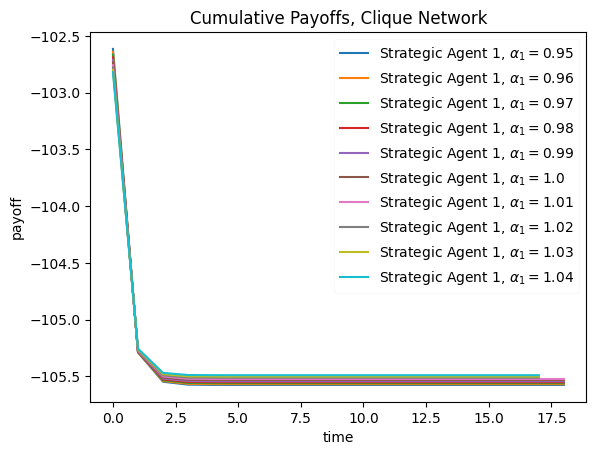

In [12]:
for i, payoffs in enumerate(A_2_payoffs):
    plt.plot(range(len(payoffs[0])), [payoffs[0][j] for j in range(len(payoffs[0]))], label = rf"Strategic Agent 1, $\alpha_1 = {alpha_1_grid[i]}$")
    
plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Clique Network")
plt.show()

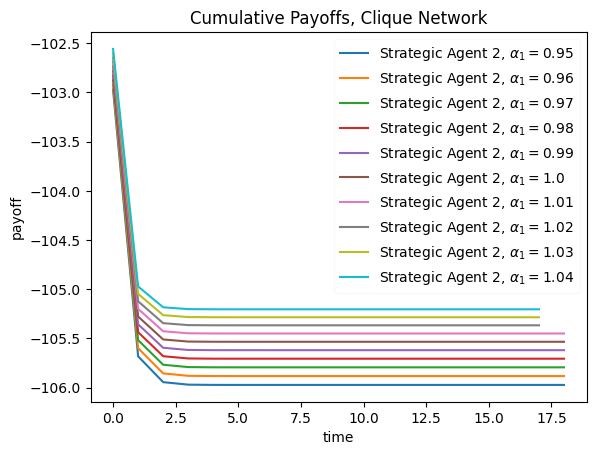

In [13]:
for i, payoffs in enumerate(A_2_payoffs):
    plt.plot(range(len(payoffs[1])), [payoffs[1][j] for j in range(len(payoffs[1]))], label = rf"Strategic Agent 2, $\alpha_1 = {alpha_1_grid[i]}$")

plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Clique Network")
plt.show()

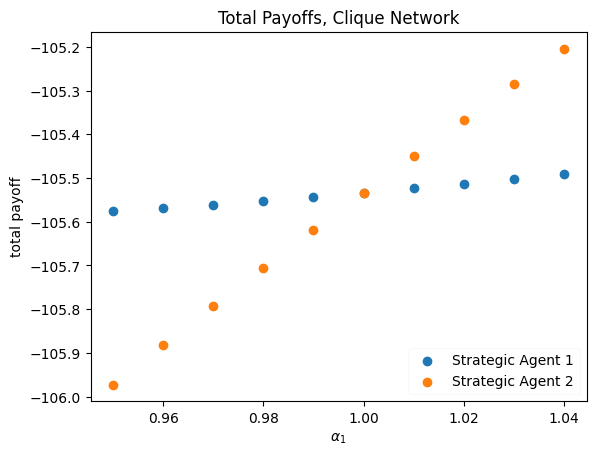

In [14]:
A_2_0_total_payoffs = []
A_2_1_total_payoffs = []
for payoffs in A_2_payoffs:
    A_2_0_total_payoffs.append(payoffs[0][-1])
    A_2_1_total_payoffs.append(payoffs[1][-1])

plt.scatter(alpha_1_grid, A_2_0_total_payoffs, label = "Strategic Agent 1")
plt.scatter(alpha_1_grid, A_2_1_total_payoffs, label = "Strategic Agent 2")

plt.xlabel(r"$\alpha_1$")
plt.ylabel("total payoff")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.title("Total Payoffs, Clique Network")
plt.show()

### Case 2: Equal $\alpha$, different agendas

In [15]:
A_2_payoffs = []
for alpha_1 in alpha_1_grid:
    xs_2_2, rs_2_2, payoffs_2_2 = run_simulation(A_2, 0, 10, alpha_1, 1)
    A_2_payoffs.append(payoffs_2_2)

alpha_1 = 0.95:

Unprojected Steady-State Opinions:
[[5.41875128]
 [5.41875128]
 [5.41875128]
 [5.41875128]]
Projected Steady-State Opinions:
[[10.83750256]
 [-0.        ]
 [ 0.        ]
 [ 0.        ]]

tilde_K^*:
1:
[[1.22303251 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]

2:
[[1.23889272 0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]

alpha_1^2 tilde_K_1 + alpha_2^2 tilde_K_2:
[[2.34267956 0.         0.         0.        ]
 [0.         1.9025     0.         0.        ]
 [0.         0.         1.9025     0.        ]
 [0.         0.         0.         1.9025    ]]




alpha_1 = 0.96:

Unprojected Steady-State Opinions:
[[5.33368872]
 [5.33368872]
 [5.33368872]
 [5.33368872]]
Projected Steady-State Opinions:
[[10.66737744]
 [-0. 

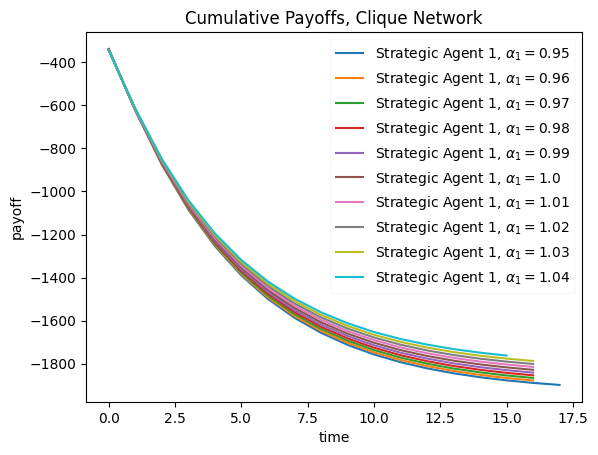

In [16]:
for i, payoffs in enumerate(A_2_payoffs):
    plt.plot(range(len(payoffs[0])), [payoffs[0][j] for j in range(len(payoffs[0]))], label = rf"Strategic Agent 1, $\alpha_1 = {alpha_1_grid[i]}$")
    
plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Clique Network")
plt.show()

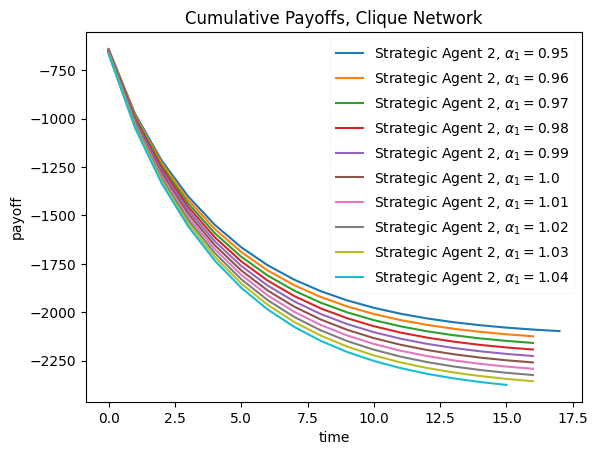

In [17]:
for i, payoffs in enumerate(A_2_payoffs):
    plt.plot(range(len(payoffs[1])), [payoffs[1][j] for j in range(len(payoffs[1]))], label = rf"Strategic Agent 2, $\alpha_1 = {alpha_1_grid[i]}$")

plt.xlabel("time")
plt.ylabel("payoff")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.title("Cumulative Payoffs, Clique Network")
plt.show()

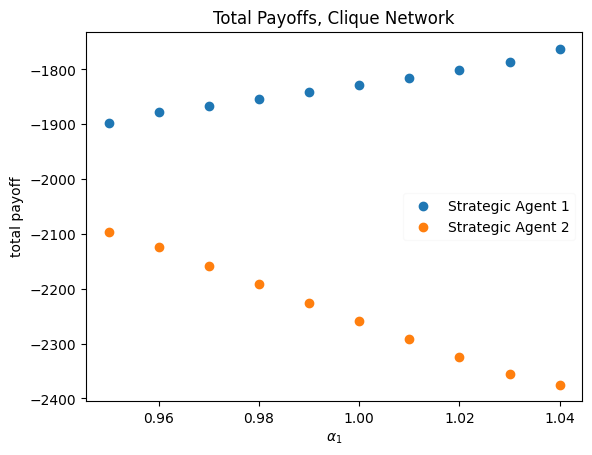

In [18]:
A_2_0_total_payoffs = []
A_2_1_total_payoffs = []
for payoffs in A_2_payoffs:
    A_2_0_total_payoffs.append(payoffs[0][-1])
    A_2_1_total_payoffs.append(payoffs[1][-1])

plt.scatter(alpha_1_grid, A_2_0_total_payoffs, label = "Strategic Agent 1")
plt.scatter(alpha_1_grid, A_2_1_total_payoffs, label = "Strategic Agent 2")

plt.xlabel(r"$\alpha_1$")
plt.ylabel("total payoff")
plt.legend(framealpha = 0.1, loc = "right")
plt.title("Total Payoffs, Clique Network")
plt.show()